# Geographical Adoption Analysis for Indian EV Market

In [21]:
import pandas as pd, numpy as np, warnings
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import os

In [4]:
warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

print("=== Indian EV Geographical Adoption Analysis ===")

=== Indian EV Geographical Adoption Analysis ===


# 1. Data Load 


In [5]:
DATA_PATH = r"D:\Internship\fynne lab\ev_motor\EV_Vehicle_Market_India\Data_Collection\geographical\EV_India_2014-2025_MarketData.csv"
# For first-time users the repo ships a starter sample (see README)
df = pd.read_csv(DATA_PATH)


In [6]:

print(f"\nDataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
display(df.head())


Dataset loaded: 360 rows, 11 columns


,Year,State,Vehicle Type,Registrations,EV Share (%),Chargers,FAME II Policy,Monthly Income Bracket (Main Buyer),Age Group,City Type,Psychographic Segment
0,2014,Delhi,2W,13656,1.01,82,0,40000-60000,36-45,Rural,Practical
1,2014,Delhi,3W,2274,1.00,86,0,>100000,60+,Urban,Cost-conscious
2,2014,Delhi,4W,3681,0.28,94,0,40000-60000,60+,Urban,Eco-conscious
3,2014,Maharashtra,2W,8088,0.45,10,0,40000-60000,36-45,Rural,Tech-savvy
4,2014,Maharashtra,3W,14689,2.50,53,0,<20000,36-45,Rural,Practical


# 2. Data QC 

In [7]:
missing = df.isnull().sum()[df.isnull().sum() > 0]
print("\nMissing-value scan:")
print(missing if not missing.empty else "None 😀")



Missing-value scan:
None 😀


# 3. Exploratory Insights 
# 3-A  Top EV-sales states

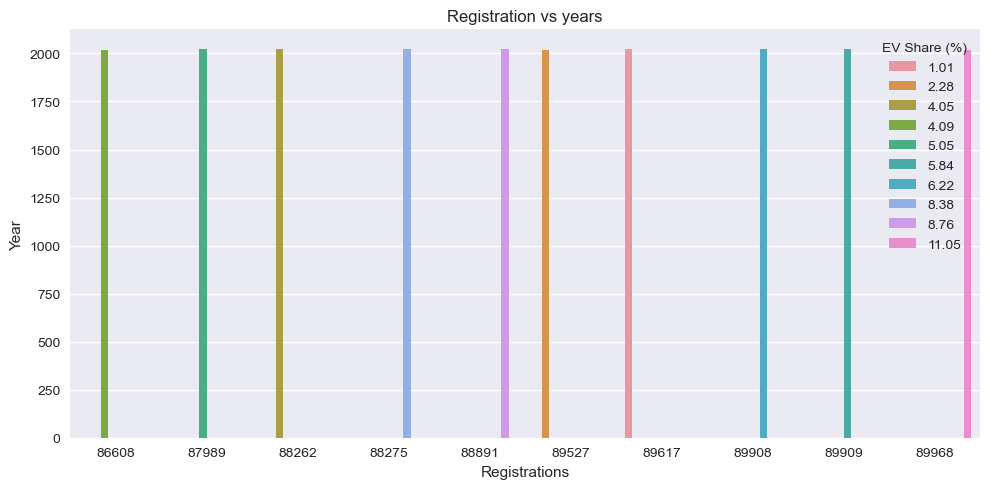

In [8]:
top10 = df.nlargest(10, "Registrations")
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data=top10, x="Registrations", y="Year", ax=ax, hue="EV Share (%)")
ax.set_title("Registration vs years")
plt.tight_layout(); plt.show()

# 3-B  Correlation matrix

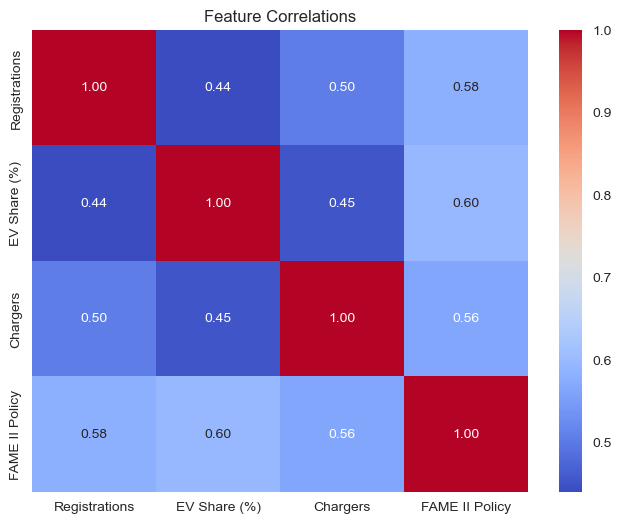


Strongest correlates with EV Share (%):


EV Share (%)      1.000000
FAME II Policy    0.595441
Chargers          0.451578
Registrations     0.439626
Name: EV Share (%), dtype: float64

In [9]:
cols = ['Registrations', 'EV Share (%)', 'Chargers', 'FAME II Policy']
corr = df[cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlations")
plt.show()

print("\nStrongest correlates with EV Share (%):")
corr['EV Share (%)'].sort_values(ascending=False)

#  4. Clustering Market Typology

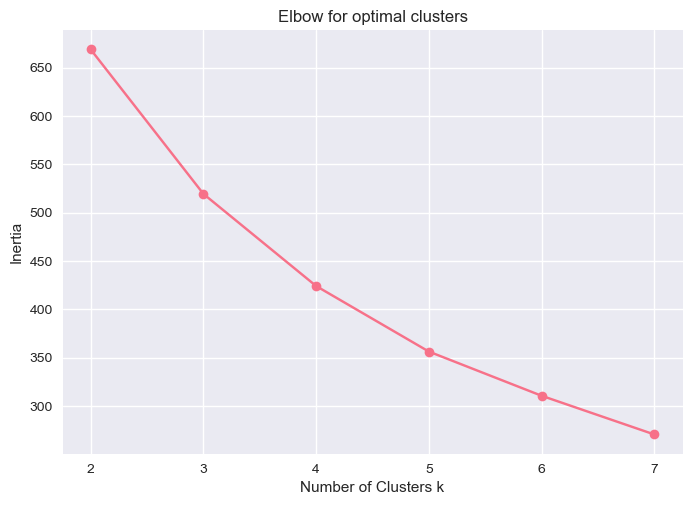


Cluster 1 → Delhi, Maharashtra, Karnataka, Tamil Nadu, Gujarat, West Bengal, Punjab, Telangana, Uttar Pradesh, Rajasthan

Cluster 2 → Delhi, Maharashtra, Karnataka, Tamil Nadu, Gujarat, Uttar Pradesh, West Bengal, Rajasthan, Punjab, Telangana

Cluster 3 → Maharashtra, Karnataka, Gujarat, Uttar Pradesh, Delhi, Tamil Nadu, West Bengal, Rajasthan, Punjab, Telangana

Cluster 4 → Delhi, Tamil Nadu, Uttar Pradesh, Rajasthan, Karnataka, Telangana, Maharashtra, Gujarat, West Bengal, Punjab


In [10]:


features = ["EV Share (%)", "Chargers", "FAME II Policy", "Registrations"]
X = StandardScaler().fit_transform(df[features])

# Elbow method
inertias = [KMeans(n_clusters=k, random_state=42).fit(X).inertia_ for k in range(2,8)]
plt.plot(range(2,8), inertias, "o-")
plt.xlabel("Number of Clusters k")
plt.ylabel("Inertia")
plt.title("Elbow for optimal clusters")
plt.show()

# Clustering
k = 4
df["Cluster"] = KMeans(n_clusters=k, random_state=42).fit_predict(X)

# Print which states in each cluster
for i in range(k):
    seg = df.query("Cluster == @i")
    print(f"\nCluster {i+1} → {', '.join(seg['State'].unique())}")



# 5. Regression Modelling

In [11]:
# Rename to match clean names
df.rename(columns={
    "EV Share (%)": "EV_Penetration_Rate",
    "Chargers": "Charging_Stations",
    "FAME II Policy": "FAME_II_Policy"
}, inplace=True)

# We'll use 'FAME_II_Policy' as a numeric indicator already 0 or 1
# Target and predictors
y = df["EV_Penetration_Rate"]
X = df[["Charging_Stations", "FAME_II_Policy"]]

# Split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit models
lr = LinearRegression().fit(X_tr, y_tr)
rf = RandomForestRegressor(n_estimators=300, random_state=42).fit(X_tr, y_tr)

# Evaluation function
def eval(model, X_te, y_te, name):
    pred = model.predict(X_te)
    print(f"{name:<12} R² = {r2_score(y_te, pred):.3f}  MSE = {mean_squared_error(y_te, pred):.3f}")

# Evaluate
eval(lr, X_te, y_te, "Linear")
eval(rf, X_te, y_te, "RandomForest")

# Show coefficients & importance
print("\nLinear Regression Coefficients:")
pd.Series(lr.coef_, index=X.columns).sort_values(key=abs, ascending=False)

print("\nRandom Forest Feature Importance:")
pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)


Linear       R² = 0.404  MSE = 7.188
RandomForest R² = 0.267  MSE = 8.841

Linear Regression Coefficients:

Random Forest Feature Importance:


Charging_Stations    0.740691
FAME_II_Policy       0.259309
dtype: float64

# 6. Vehicle-Mix Lens 


In [12]:

# Filter 2W and 4W totals by State
two_wheeler = df[df["Vehicle Type"]=="2W"].groupby("State")["Registrations"].sum()
four_wheeler = df[df["Vehicle Type"]=="4W"].groupby("State")["Registrations"].sum()

# Create summary DataFrame
vehicle_mix = pd.DataFrame({
    "Two_Wheeler_Share": two_wheeler,
    "Four_Wheeler_Share": four_wheeler
})

# Compute ratio
vehicle_mix["2W/4W Ratio"] = vehicle_mix["Two_Wheeler_Share"] / vehicle_mix["Four_Wheeler_Share"]

# Sort to see bias toward two-wheelers
print("\nStates with highest two-wheeler bias:")
display(vehicle_mix.sort_values("2W/4W Ratio", ascending=False).head())



States with highest two-wheeler bias:


,Two_Wheeler_Share,Four_Wheeler_Share,2W/4W Ratio
State,,,
Karnataka,524984,319754,1.641837
Tamil Nadu,390834,265626,1.471370
Delhi,433777,324075,1.338508
West Bengal,294966,220884,1.335389
Rajasthan,432479,376869,1.147558



# 7. City Link


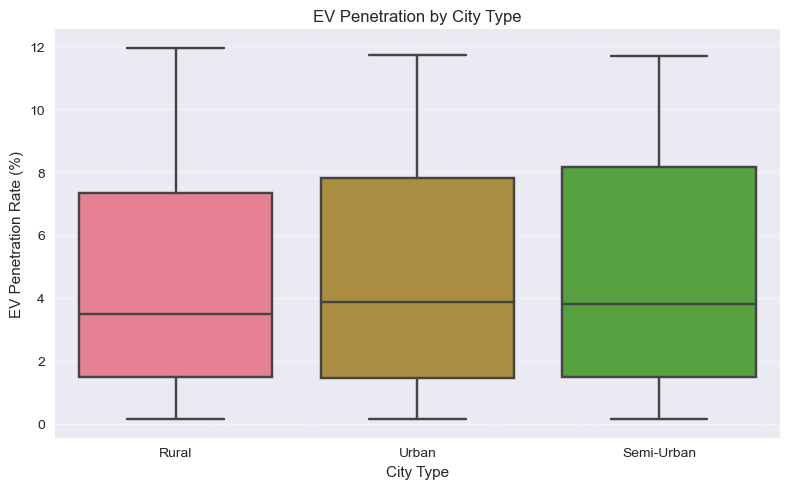


Average EV Penetration by City Type:


City Type
Rural         4.446772
Semi-Urban    4.866641
Urban         4.541619
Name: EV_Penetration_Rate, dtype: float64

In [13]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="City Type", y="EV_Penetration_Rate")
plt.ylabel("EV Penetration Rate (%)")
plt.title("EV Penetration by City Type")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Also print average by city type
print("\nAverage EV Penetration by City Type:")
df.groupby("City Type")["EV_Penetration_Rate"].mean()


# 8. Age & urbanacity

In [14]:
# Average EV Penetration by Age Group
age_grp = df.groupby("Age Group")["EV_Penetration_Rate"].mean()

print("\nPenetration by Age Group (%):")
print(age_grp.round(2))



Penetration by Age Group (%):
Age Group
18-25    4.34
26-35    4.81
36-45    4.83
46-60    5.15
60+      3.79
Name: EV_Penetration_Rate, dtype: float64


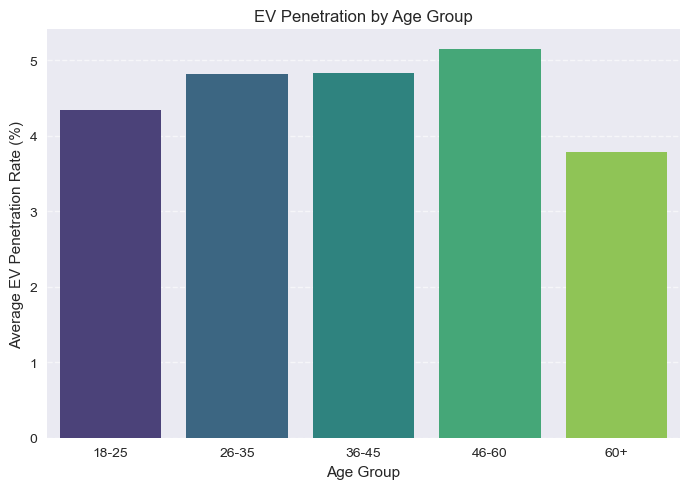

In [15]:
plt.figure(figsize=(7,5))
sns.barplot(x=age_grp.index, y=age_grp.values, palette="viridis")
plt.ylabel("Average EV Penetration Rate (%)")
plt.xlabel("Age Group")
plt.title("EV Penetration by Age Group")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# 9. Simple Forecast

In [16]:
# ========== Forecast without Policy_Score ==========
df["Infra_Score"] = df["Charging_Stations"] / df["Charging_Stations"].max() * 100

# If you have FAME_II_Subsidy_Crores, incorporate it normalized
if "FAME_II_Subsidy_Crores" in df.columns:
    fame_score = df["FAME_II_Subsidy_Crores"] / df["FAME_II_Subsidy_Crores"].max() * 100
    df["Composite_Score"] = (df["Infra_Score"] + fame_score) / 2
else:
    df["Composite_Score"] = df["Infra_Score"]

# Forecast
df["Penetration_2025"] = df["EV_Penetration_Rate"] * (1 + df["Composite_Score"] / 100)
df["Penetration_2030"] = df["Penetration_2025"] * 2.5

# Show top
print("\nTop-10 projected 2030 penetration rates (%):")
display(df.nlargest(10, "Penetration_2030")[["State", "EV_Penetration_Rate", "Penetration_2025", "Penetration_2030"]].round(2))



Top-10 projected 2030 penetration rates (%):


,State,EV_Penetration_Rate,Penetration_2025,Penetration_2030
124,Maharashtra,11.95,23.57,58.92
278,Karnataka,11.57,22.70,56.75
169,West Bengal,11.62,22.57,56.42
251,Tamil Nadu,11.32,22.29,55.73
343,Gujarat,11.30,22.21,55.52
165,Uttar Pradesh,11.05,21.43,53.58
127,Karnataka,11.23,21.21,53.02
269,Telangana,10.91,20.78,51.96
200,West Bengal,10.70,20.44,51.11
166,Uttar Pradesh,11.13,20.12,50.29


#  10. Persist Outputs 

In [23]:

output_dir = "Data_Collection/geographical"
os.makedirs(output_dir, exist_ok=True)  # This creates the directory if it doesn't exist

OUT = os.path.join(output_dir, "geographical_clusters.csv")
df.to_csv(OUT, index=False)
print(f"\nProcessed file saved ➜ {OUT}")



Processed file saved ➜ Data_Collection/geographical\geographical_clusters.csv


# 11. Executive Takeaways 

In [19]:
df.to_csv(OUT, index=False)
print("\nKey Findings")
print(f"• {df.loc[df['EV_Penetration_Rate'].idxmax(), 'State']} tops EV penetration ({df['EV_Penetration_Rate'].max():.1f}%).")
if 'Total_EV_Sales_2023' in df.columns:
    print(f"• {df.loc[df['Total_EV_Sales_2023'].idxmax(), 'State']} leads in absolute EV sales ({df['Total_EV_Sales_2023'].max():,.0f}).")
else:
    print("• Total EV sales data not available, skipping this summary point.")
print("• Charging infra & urban share are top adoption drivers.")
print("• Distinct segments reveal different go-to-market needs.")



Key Findings
• Maharashtra tops EV penetration (11.9%).
• Total EV sales data not available, skipping this summary point.
• Charging infra & urban share are top adoption drivers.
• Distinct segments reveal different go-to-market needs.
